# Covid 19 Identification with Chest X Ray


Created By Lalith Kahatapitiya at [PGIS](http://www.pgis.pdn.ac.lk/) - University of Peradeniya

# Data set Credit :
1. [Covid Chest X Ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset)
2. [Pneumonia dataset by Praveen](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)
3. [COVID19 chest XRAY analysis by SAIMANASA_C](https://www.kaggle.com/code/saimanasachadalavada/covid19-chest-xray-analysis/data)
4. [COVID19 with Pneumonia and Normal Chest Xray(PA) Dataset by AMANULLAH ASRAF](https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset)
5. [HASH_Directors - Covid19 by AMRUTH AMBRISH K](https://www.kaggle.com/code/amruthambrish/hash-directors-covid19/data)
6. [RICORD COVID-19 X-ray positive tests by RADDAR](https://www.kaggle.com/datasets/raddar/ricord-covid19-xray-positive-tests)


# This is the result from each version run on the Kaggle.

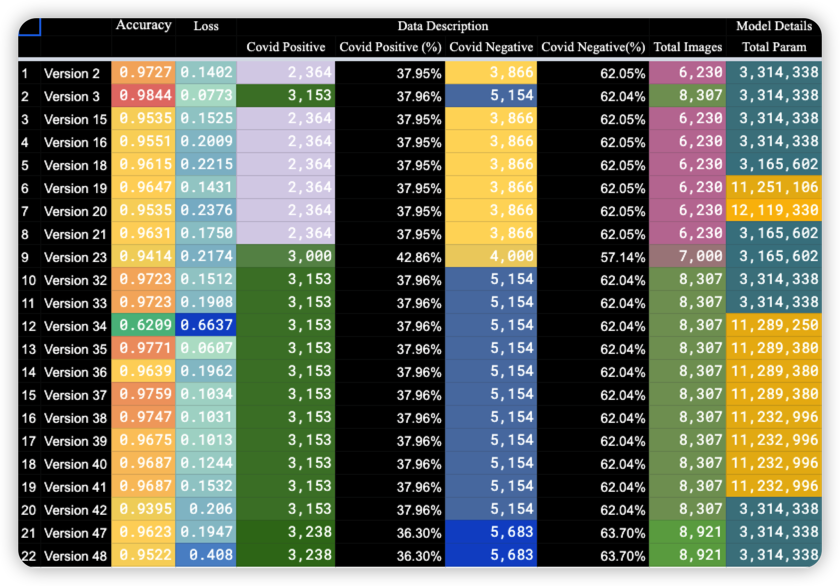


[Datasheet](https://docs.google.com/spreadsheets/d/1wtD3Gx3iLCJO_bs5j1wgDMO9EsDAjMM1aXyK1AUhnHY/edit?usp=sharing)

# System Parameter show




In [1]:
import sys
import platform
import os
import datetime
import pytz
timezone = pytz.timezone("Asia/Colombo")
import random

import shutil

import tensorflow.keras
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print()
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
print(f"Open CV {cv2.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


# def working_dir_clean():
#     list_all_file=os.listdir("./")
#     for file_name in list_all_file:
#         try:
#             shutil.rmtree("./"+file_name)
#             print(f"Remove File Name : {file_name}")
        
#         except Exception as e:
#             print('Exception:',e)
#                     #if any exception rasied, the exception will be printed here. And pass to the next image
        
# working_dir_clean()

Python Platform: macOS-12.6-arm64-arm-64bit
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
Open CV 4.6.0

GPU is available


# Data Set Location Verified and Find Image's Folder

In [2]:
# image data set_path mapping check folder names
dataset_path = 'TRAINING'
# categories = os.listdir(dataset_path)
# print(categories)

# Data Labels creation

In [3]:
categories_all = os.listdir(dataset_path)
categories = []
for category in categories_all:
    if (category == ".DS_Store"):
        continue
    else:
        categories.append(category)

labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))  # empty dictionary


print(label_dict)
print(categories)
print(labels)

{'NORMAL': 0, 'COVID': 1}
['NORMAL', 'COVID']
[0, 1]


# Images count in each folder

In [4]:
# "COVID-19"
folder_path_covid =[
    "TRAINING/COVID",
]


img_path_covid_old =[]
for folder_path in folder_path_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_covid_old.append(img_path)
        


# "NON-COVID"
folder_path_non_covid =[
"TRAINING/NORMAL",
]



img_path_non_covid_old =[]
for folder_path in folder_path_non_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_non_covid_old.append(img_path)

        # images array shuffles
img_path_covid_old = random.sample(img_path_covid_old, len(img_path_covid_old))
img_path_non_covid_old = random.sample(img_path_non_covid_old, len(img_path_non_covid_old))
 
total_ca_images = len(img_path_covid_old) + len(img_path_non_covid_old)

print(f"Containe Covid images count     : {len(img_path_covid_old)}")           
print(f"Non covid images count : {len(img_path_non_covid_old)}")   
print(f"All images count       : {total_ca_images} \n")     
        
#  images array lenth 
divider = 1
middle_img_path_covid = int(len(img_path_covid_old)/divider)
middle_img_path_non_covid = int(len(img_path_non_covid_old)/divider)

# middle_img_path_covid = 4099
# middle_img_path_non_covid = middle_img_path_covid

img_path_covid =img_path_covid_old[:middle_img_path_covid]
img_path_non_covid =img_path_non_covid_old[:middle_img_path_non_covid]

total_images = len(img_path_non_covid) + len(img_path_covid)

print(f"Covid images count     : {len(img_path_covid)}")           
print(f"Non covid images count : {len(img_path_non_covid)}")   
print(f"All images count       : {total_images}") 
print(f"Covid images           : {round((len(img_path_covid)/total_images)*100, 2)} %")           
print(f"Non covid images       : {round((len(img_path_non_covid)/total_images)*100, 2)} %")  

Containe Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460 

Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460
Covid images           : 43.33 %
Non covid images       : 56.67 %


# Read selected images to array

In [5]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start images reading :{start_time}")
img_size = 224
data = []
target = []
covid = []
normal = []


def image_read(img_path):
    img = cv2.imread(img_path)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Coverting the image into gray scale
        resized = cv2.resize(gray, (img_size, img_size))
        # resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
        return True, resized

    except Exception as e:

        # if any exception rasied, the exception will be return here. And pass to the next image
        return False, e


for img_path in img_path_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("non covid images error")
    else:
        covid.append(resized)
        target.append(label_dict["COVID"])


for img_path in img_path_non_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("covid images error")
    else:
        normal.append(resized)
        target.append(label_dict["NORMAL"])


data = covid + normal
end_time = datetime.datetime.now(tz=timezone)
print(f"End images reading :{end_time}")

print(f"Total time taken {end_time-start_time}")


Start images reading :2022-10-27 12:38:09.502932+05:30


libpng warning: cHRM: invalid values


covid images error
End images reading :2022-10-27 12:39:55.468877+05:30
Total time taken 0:01:45.965945


# Normal Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 295.89it/s]


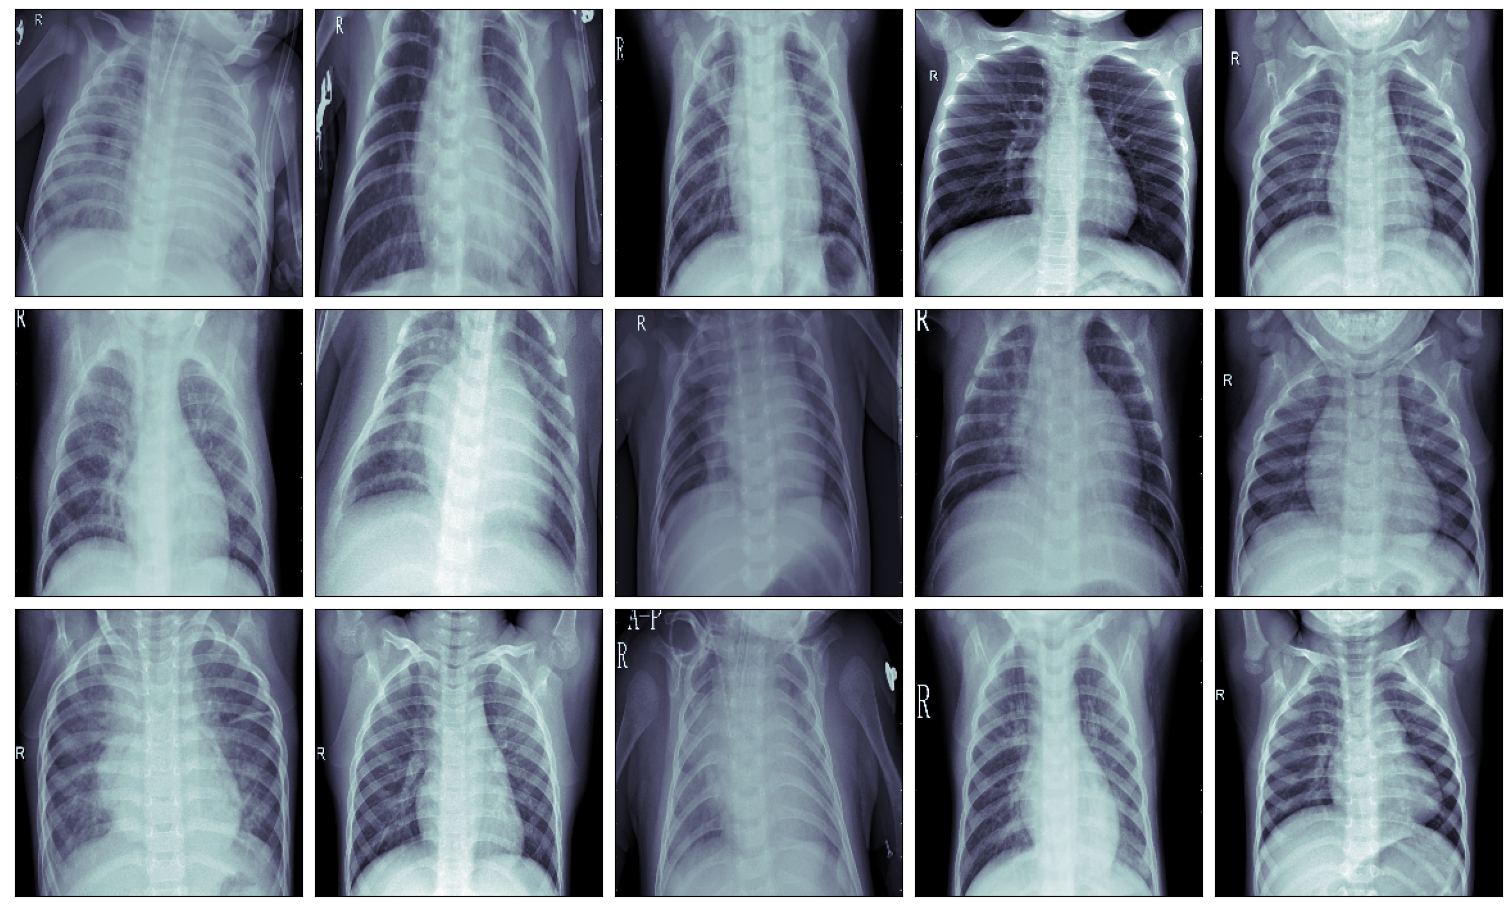

In [6]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        ax[row][col].imshow(normal[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Covid Positive Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 547.85it/s]


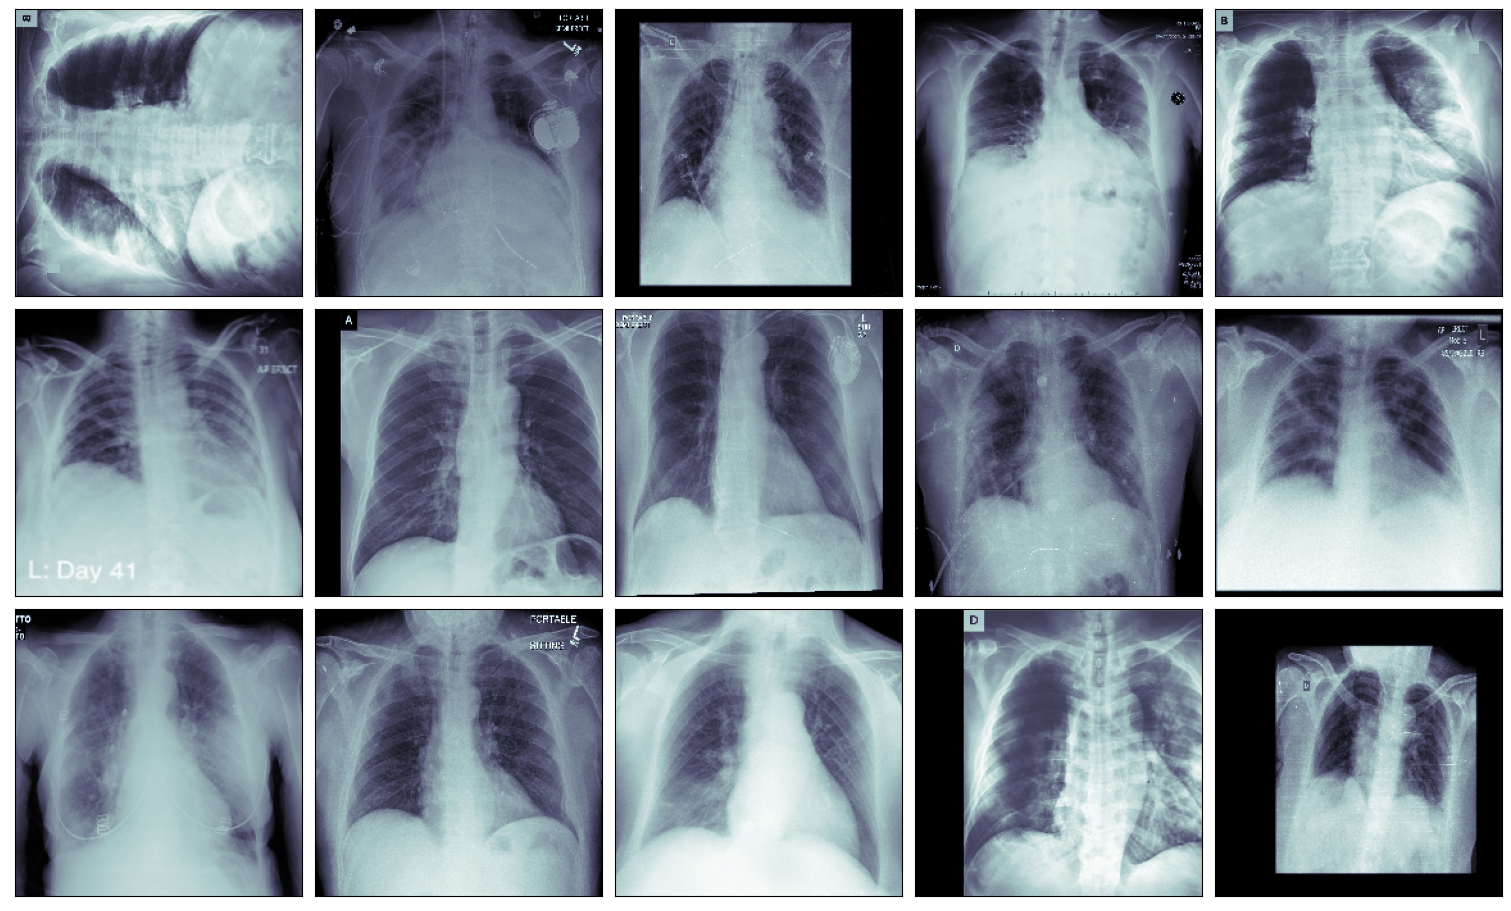

In [7]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(covid[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Wanbd configuration 

In [8]:
wandb_api_key = '52c82ac93c7b3a43eab4eee3ee4264af086187eb'
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback


start_time = datetime.datetime.now(tz=timezone)
name =f'{start_time}-model-run'
wandb.init(
    project="covid-19-identification-with-chest-x-ray",
    name=name
)
# wandb. init(mode="disabled")

W&B:  0.13.4


wandb: Currently logged in as: lalithk90. Use `wandb login --relogin` to force relogin


# Data array transfer to numpy array and change shape

In [9]:

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


new_target=tf.keras.utils.to_categorical(target)


print(f"Data shape : {data.shape} \nTarget shape : {target.shape} \nNew Target shape : {new_target.shape}")

Data shape : (9459, 224, 224, 1) 
Target shape : (9459,) 
New Target shape : (9459, 2)


# Model Creation



In [10]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint


input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7,9]

for k in range(len(parrallel_kernels)):
    if(k !=0):
        conv = Conv2D(128, kernel_size = k,padding = 'same' ,activation='relu')(inp)

        convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

# Hidden Layer 2
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden Layer 3
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Output layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='sigmoid'))



Metal device set to: Apple M1 Pro


2022-10-27 12:40:05.861911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 12:40:05.862818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model Compile

In [11]:
METRICS = [
    'accuracy',
    "sparse_categorical_accuracy",
    'mean_squared_error',
    'mean_absolute_error',
    'mean_absolute_percentage_error',
    'mean_squared_logarithmic_error',
    'cosine_similarity',
    'logcosh',
]

LOSS = 'sparse_categorical_crossentropy'

OPTIMIZER = 'adam'

model.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

# Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 384)     2176      
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      221248    
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                        

# Data Array Spliting

In [13]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

print(type (train_data))
print(f"Training Data shape : {train_data.shape} \nTraining Target shape : {train_target.shape}")
print(f"Test Data shape : {test_data.shape} \nTest Target shape : {test_target.shape}")

<class 'numpy.ndarray'>
Training Data shape : (8513, 224, 224, 1) 
Training Target shape : (8513,)
Test Data shape : (946, 224, 224, 1) 
Test Target shape : (946,)


# Model Training

In [15]:


start_time = datetime.datetime.now(tz=timezone)
print(f"Start checkpoint creation:{start_time}")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

print(len(train_data))
history=model.fit(train_data,
                  train_target,
                  epochs = 25,
                  callbacks=[checkpoint,WandbCallback()],
                  validation_data = (test_data,test_target))

end_time = datetime.datetime.now(tz=timezone)
print(f"End checkpoint creation:{end_time}")
print(f"Total time taken {end_time-start_time}")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Start checkpoint creation:2022-10-27 12:51:14.867943+05:30
8513
Epoch 1/25
  6/267 [..............................] - ETA: 7:16 - loss: 0.1012 - accuracy: 0.9792 - sparse_categorical_accuracy: 0.9792 - mean_squared_error: 0.3921 - mean_absolute_error: 0.4855 - mean_absolute_percentage_error: 239083136.0000 - mean_squared_logarithmic_error: 0.1886 - cosine_similarity: 0.5520 - logcosh: 0.1748WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.5450s vs `on_train_batch_end` time: 1.2107s). Check your callbacks.


267/267 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9696 - sparse_categorical_accuracy: 0.9696 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4676 - mean_absolute_percentage_error: 251803904.0000 - mean_squared_logarithmic_error: 0.1827 - cosine_similarity: 0.5044 - logcosh: 0.1692
Epoch 1: val_accuracy improved from -inf to 0.98309, saving model to model-001.model


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 441s 2s/step - loss: 0.0932 - accuracy: 0.9696 - sparse_categorical_accuracy: 0.9696 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4676 - mean_absolute_percentage_error: 251803904.0000 - mean_squared_logarithmic_error: 0.1827 - cosine_similarity: 0.5044 - logcosh: 0.1692 - val_loss: 0.0732 - val_accuracy: 0.9831 - val_sparse_categorical_accuracy: 0.9831 - val_mean_squared_error: 0.4050 - val_mean_absolute_error: 0.5024 - val_mean_absolute_percentage_error: 260421872.0000 - val_mean_squared_logarithmic_error: 0.1932 - val_cosine_similarity: 0.5035 - val_logcosh: 0.1809
Epoch 2/25
267/267 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9749 - sparse_categorical_accuracy: 0.9749 - mean_squared_error: 0.3744 - mean_absolute_error: 0.4564 - mean_absolute_percentage_error: 252425040.0000 - mean_squared_logarithmic_error: 0.1806 - cosine_similarity: 0.5011 - logcosh: 0.1664
Epoch 2: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 437s 2s/step - loss: 0.0790 - accuracy: 0.9749 - sparse_categorical_accuracy: 0.9749 - mean_squared_error: 0.3744 - mean_absolute_error: 0.4564 - mean_absolute_percentage_error: 252425040.0000 - mean_squared_logarithmic_error: 0.1806 - cosine_similarity: 0.5011 - logcosh: 0.1664 - val_loss: 0.0604 - val_accuracy: 0.9820 - val_sparse_categorical_accuracy: 0.9820 - val_mean_squared_error: 0.4077 - val_mean_absolute_error: 0.4883 - val_mean_absolute_percentage_error: 270511392.0000 - val_mean_squared_logarithmic_error: 0.1957 - val_cosine_similarity: 0.4957 - val_logcosh: 0.1814
Epoch 3/25
267/267 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9751 - sparse_categorical_accuracy: 0.9751 - mean_squared_error: 0.3693 - mean_absolute_error: 0.4432 - mean_absolute_percentage_error: 242767040.0000 - mean_squared_logarithmic_error: 0.1780 - cosine_similarity: 0.4967 - logcosh: 0.1638
Epoch 3: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 432s 2s/step - loss: 0.0561 - accuracy: 0.9817 - sparse_categorical_accuracy: 0.9817 - mean_squared_error: 0.3772 - mean_absolute_error: 0.4475 - mean_absolute_percentage_error: 255342928.0000 - mean_squared_logarithmic_error: 0.1817 - cosine_similarity: 0.4985 - logcosh: 0.1671 - val_loss: 0.0589 - val_accuracy: 0.9820 - val_sparse_categorical_accuracy: 0.9820 - val_mean_squared_error: 0.4078 - val_mean_absolute_error: 0.4738 - val_mean_absolute_percentage_error: 262824208.0000 - val_mean_squared_logarithmic_error: 0.1947 - val_cosine_similarity: 0.4971 - val_logcosh: 0.1810
Epoch 5/25
267/267 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9858 - sparse_categorical_accuracy: 0.9858 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4416 - mean_absolute_percentage_error: 257183680.0000 - mean_squared_logarithmic_error: 0.1835 - cosine_similarity: 0.4958 - logcosh: 0.1679
Epoch 5: val_accuracy improved from 0.98309 t

INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 428s 2s/step - loss: 0.0457 - accuracy: 0.9858 - sparse_categorical_accuracy: 0.9858 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4416 - mean_absolute_percentage_error: 257183680.0000 - mean_squared_logarithmic_error: 0.1835 - cosine_similarity: 0.4958 - logcosh: 0.1679 - val_loss: 0.0417 - val_accuracy: 0.9905 - val_sparse_categorical_accuracy: 0.9905 - val_mean_squared_error: 0.4128 - val_mean_absolute_error: 0.4721 - val_mean_absolute_percentage_error: 268820352.0000 - val_mean_squared_logarithmic_error: 0.1958 - val_cosine_similarity: 0.5006 - val_logcosh: 0.1827
Epoch 6/25
267/267 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9886 - sparse_categorical_accuracy: 0.9886 - mean_squared_error: 0.3860 - mean_absolute_error: 0.4412 - mean_absolute_percentage_error: 259096416.0000 - mean_squared_logarithmic_error: 0.1864 - cosine_similarity: 0.4927 - logcosh: 0.1702
Epoch 6: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 417s 2s/step - loss: 0.0313 - accuracy: 0.9911 - sparse_categorical_accuracy: 0.9911 - mean_squared_error: 0.3821 - mean_absolute_error: 0.4351 - mean_absolute_percentage_error: 256182432.0000 - mean_squared_logarithmic_error: 0.1841 - cosine_similarity: 0.4952 - logcosh: 0.1685 - val_loss: 0.0362 - val_accuracy: 0.9884 - val_sparse_categorical_accuracy: 0.9884 - val_mean_squared_error: 0.4178 - val_mean_absolute_error: 0.4722 - val_mean_absolute_percentage_error: 270774848.0000 - val_mean_squared_logarithmic_error: 0.1978 - val_cosine_similarity: 0.4994 - val_logcosh: 0.1846
Epoch 10/25
267/267 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9938 - sparse_categorical_accuracy: 0.9938 - mean_squared_error: 0.3910 - mean_absolute_error: 0.4356 - mean_absolute_percentage_error: 264040848.0000 - mean_squared_logarithmic_error: 0.1877 - cosine_similarity: 0.4968 - logcosh: 0.1719
Epoch 10: val_accuracy did not improve from 

INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 412s 2s/step - loss: 0.0191 - accuracy: 0.9938 - sparse_categorical_accuracy: 0.9938 - mean_squared_error: 0.3910 - mean_absolute_error: 0.4356 - mean_absolute_percentage_error: 264040848.0000 - mean_squared_logarithmic_error: 0.1877 - cosine_similarity: 0.4968 - logcosh: 0.1719 - val_loss: 0.0265 - val_accuracy: 0.9894 - val_sparse_categorical_accuracy: 0.9894 - val_mean_squared_error: 0.4410 - val_mean_absolute_error: 0.4809 - val_mean_absolute_percentage_error: 275912448.0000 - val_mean_squared_logarithmic_error: 0.2085 - val_cosine_similarity: 0.4873 - val_logcosh: 0.1938
Epoch 11/25
 33/267 [==>...........................] - ETA: 5:49 - loss: 0.0079 - accuracy: 0.9962 - sparse_categorical_accuracy: 0.9962 - mean_squared_error: 0.3963 - mean_absolute_error: 0.4409 - mean_absolute_percentage_error: 264795120.0000 - mean_squared_logarithmic_error: 0.1898 - cosine_similarity: 0.4798 - logcosh: 0.1743

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0x2e4da7ce0>
    label = <none> 
    device = <AGXG13XDevice: 0x141290600>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x117032000>
        label = <none> 
        device = <AGXG13XDevice: 0x141290600>
            name = Apple M1 Pro 
    retainedReferences = 1


267/267 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9941 - sparse_categorical_accuracy: 0.9941 - mean_squared_error: 0.3984 - mean_absolute_error: 0.4404 - mean_absolute_percentage_error: 265534816.0000 - mean_squared_logarithmic_error: 0.1911 - cosine_similarity: 0.4931 - logcosh: 0.1751
Epoch 11: val_accuracy did not improve from 0.99049
267/267 [==============================] - 414s 2s/step - loss: 0.0166 - accuracy: 0.9941 - sparse_categorical_accuracy: 0.9941 - mean_squared_error: 0.3984 - mean_absolute_error: 0.4404 - mean_absolute_percentage_error: 265534816.0000 - mean_squared_logarithmic_error: 0.1911 - cosine_similarity: 0.4931 - logcosh: 0.1751 - val_loss: 0.0401 - val_accuracy: 0.9884 - val_sparse_categorical_accuracy: 0.9884 - val_mean_squared_error: 0.4211 - val_mean_absolute_error: 0.4752 - val_mean_absolute_percentage_error: 273502368.0000 - val_mean_squared_logarithmic_error: 0.1994 - val_cosine_similarity: 0.4997 - val_logcosh: 0.1859
Epoc

INFO:tensorflow:Assets written to: model-013.model/assets


INFO:tensorflow:Assets written to: model-013.model/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lalithk90/Desktop/Independent Study/FINAL CUT/Covid-19-Identification-with-Chest-X-Ray/wandb/run-20221027_123959-21zgxfo3/files/model-best)... Done. 0.3s


267/267 [==============================] - 424s 2s/step - loss: 0.0120 - accuracy: 0.9953 - sparse_categorical_accuracy: 0.9953 - mean_squared_error: 0.3976 - mean_absolute_error: 0.4346 - mean_absolute_percentage_error: 270043936.0000 - mean_squared_logarithmic_error: 0.1904 - cosine_similarity: 0.4984 - logcosh: 0.1745 - val_loss: 0.0236 - val_accuracy: 0.9937 - val_sparse_categorical_accuracy: 0.9937 - val_mean_squared_error: 0.4459 - val_mean_absolute_error: 0.4760 - val_mean_absolute_percentage_error: 274943360.0000 - val_mean_squared_logarithmic_error: 0.2103 - val_cosine_similarity: 0.4856 - val_logcosh: 0.1955
Epoch 14/25
267/267 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9932 - sparse_categorical_accuracy: 0.9932 - mean_squared_error: 0.3902 - mean_absolute_error: 0.4266 - mean_absolute_percentage_error: 270913600.0000 - mean_squared_logarithmic_error: 0.1864 - cosine_similarity: 0.5067 - logcosh: 0.1712
Epoch 14: val_accuracy did not improve from 

Epoch 22/25
267/267 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9836 - sparse_categorical_accuracy: 0.9836 - mean_squared_error: 0.3465 - mean_absolute_error: 0.3771 - mean_absolute_percentage_error: 259056624.0000 - mean_squared_logarithmic_error: 0.1664 - cosine_similarity: 0.5312 - logcosh: 0.1517
Epoch 22: val_accuracy did not improve from 0.99366
267/267 [==============================] - 445s 2s/step - loss: 0.0138 - accuracy: 0.9836 - sparse_categorical_accuracy: 0.9836 - mean_squared_error: 0.3465 - mean_absolute_error: 0.3771 - mean_absolute_percentage_error: 259056624.0000 - mean_squared_logarithmic_error: 0.1664 - cosine_similarity: 0.5312 - logcosh: 0.1517 - val_loss: 0.0330 - val_accuracy: 0.9926 - val_sparse_categorical_accuracy: 0.9926 - val_mean_squared_error: 0.4267 - val_mean_absolute_error: 0.4608 - val_mean_absolute_percentage_error: 276900224.0000 - val_mean_squared_logarithmic_error: 0.1986 - val_cosine_similarity: 0.5086 - val_logcosh:

INFO:tensorflow:Assets written to: model-024.model/assets


INFO:tensorflow:Assets written to: model-024.model/assets


267/267 [==============================] - 427s 2s/step - loss: 0.0045 - accuracy: 0.9695 - sparse_categorical_accuracy: 0.9695 - mean_squared_error: 0.3476 - mean_absolute_error: 0.3738 - mean_absolute_percentage_error: 259000928.0000 - mean_squared_logarithmic_error: 0.1665 - cosine_similarity: 0.5325 - logcosh: 0.1520 - val_loss: 0.0269 - val_accuracy: 0.9947 - val_sparse_categorical_accuracy: 0.9947 - val_mean_squared_error: 0.4623 - val_mean_absolute_error: 0.4810 - val_mean_absolute_percentage_error: 277721152.0000 - val_mean_squared_logarithmic_error: 0.2183 - val_cosine_similarity: 0.4764 - val_logcosh: 0.2020
Epoch 25/25
267/267 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9582 - sparse_categorical_accuracy: 0.9582 - mean_squared_error: 0.3465 - mean_absolute_error: 0.3708 - mean_absolute_percentage_error: 263459776.0000 - mean_squared_logarithmic_error: 0.1664 - cosine_similarity: 0.5367 - logcosh: 0.1515
Epoch 25: val_accuracy did not improve from 

# Model Save

In [16]:
model.save('model.h5')

In [18]:
layers = model.layers
print(layers)

[<keras.engine.functional.Functional object at 0x175d91d30>, <keras.layers.convolutional.conv2d.Conv2D object at 0x29e2dff10>, <keras.layers.core.activation.Activation object at 0x29e2df940>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x29e3359a0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x17cca7460>, <keras.layers.core.activation.Activation object at 0x175d91d60>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17cca70d0>, <keras.layers.reshaping.flatten.Flatten object at 0x108228d30>, <keras.layers.regularization.dropout.Dropout object at 0x29e24a4c0>, <keras.layers.core.dense.Dense object at 0x169b8d7c0>, <keras.layers.regularization.dropout.Dropout object at 0x29e33b7f0>, <keras.layers.core.dense.Dense object at 0x169b64f40>, <keras.layers.regularization.dropout.Dropout object at 0x169b64700>, <keras.layers.core.dense.Dense object at 0x169b64d30>, <keras.layers.regularization.dropout.Dropout object at 0x169a9d7c0>, <keras.layers.core.dense.D

# Plot model to png

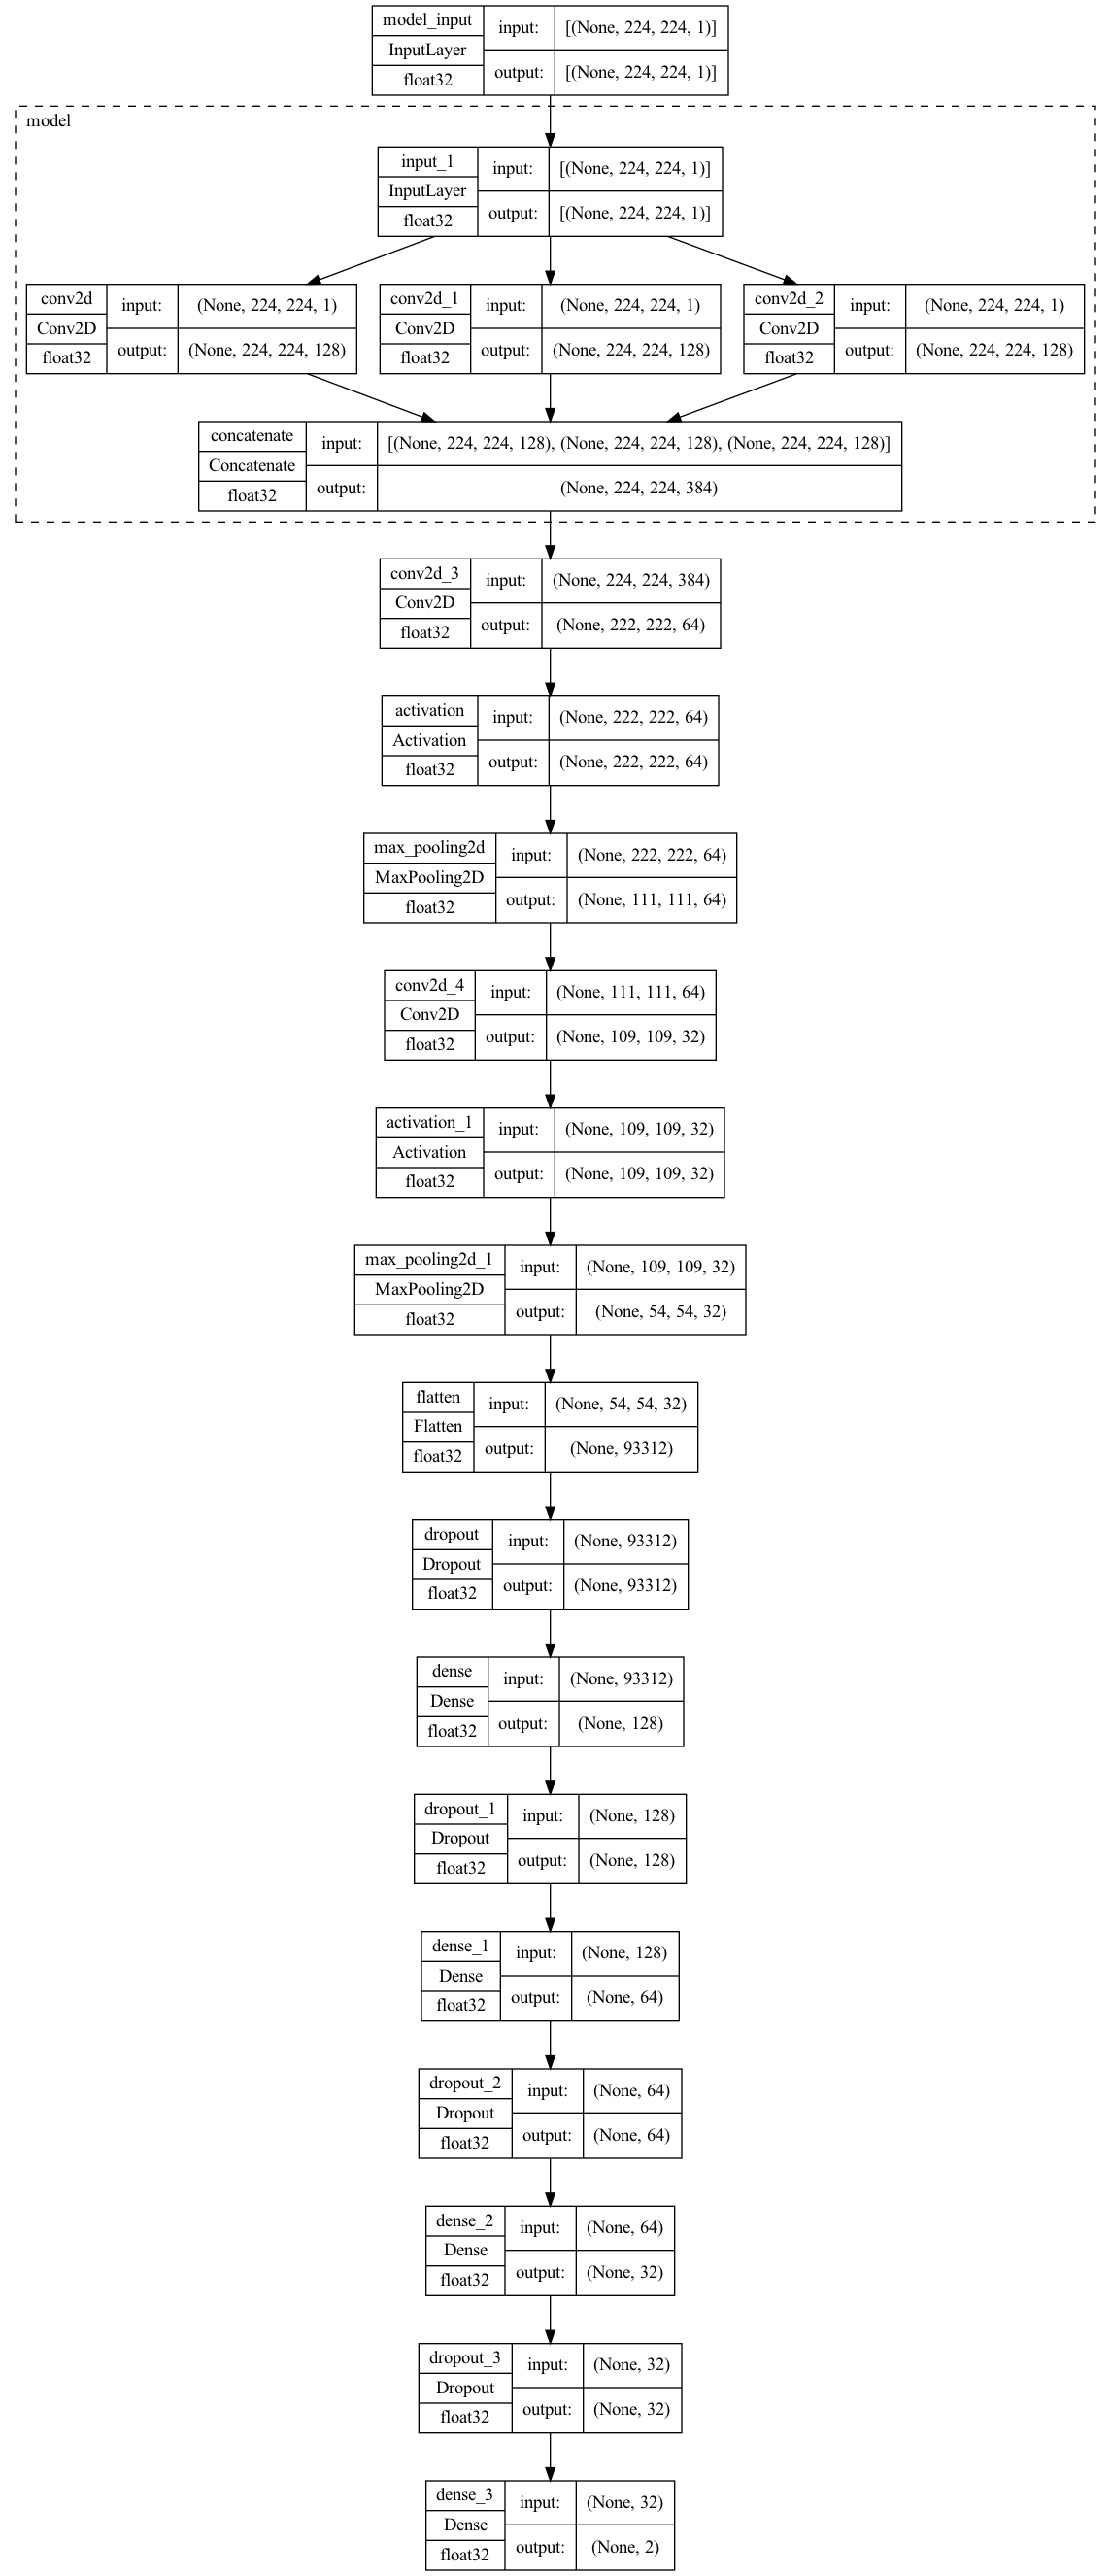

In [19]:
# plot model as image
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)

In [20]:
#date labeling confusion was removed 

X_train =train_data
Y_train =train_target

x_test =test_data
y_test = test_target


# Valued to plot in epochs traing's history

## Training and validation accuracy Model

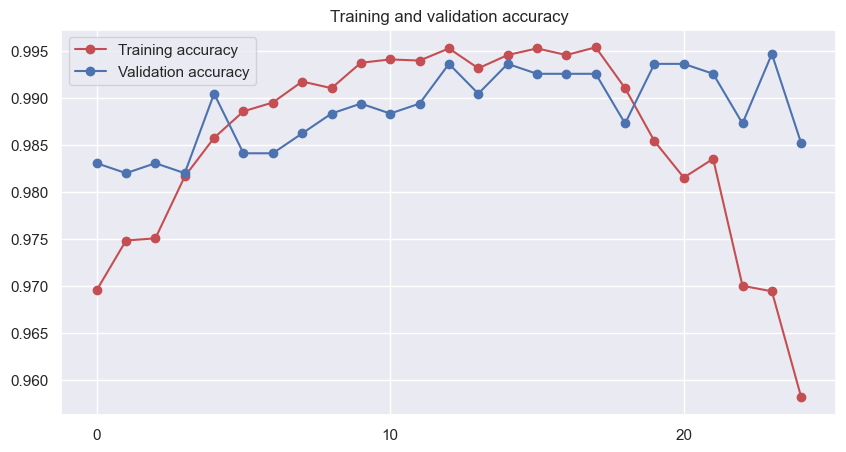

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy', marker="o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker="o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()
plt.show()

## Training and validation Loss Model

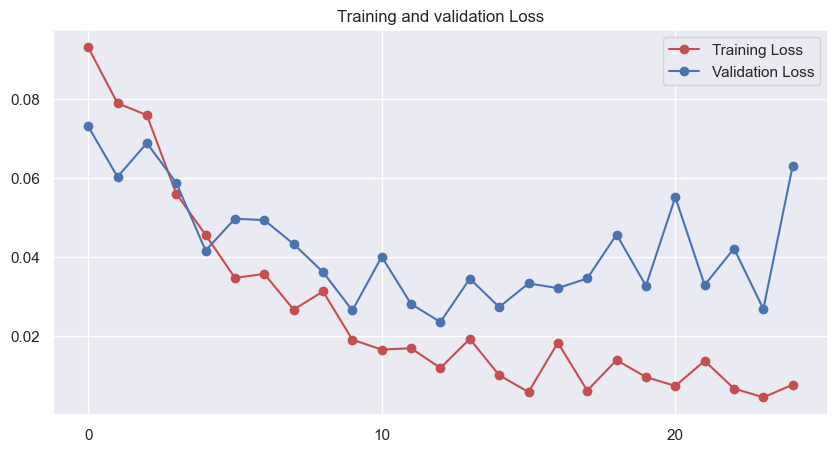

<Figure size 640x480 with 0 Axes>

In [22]:
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

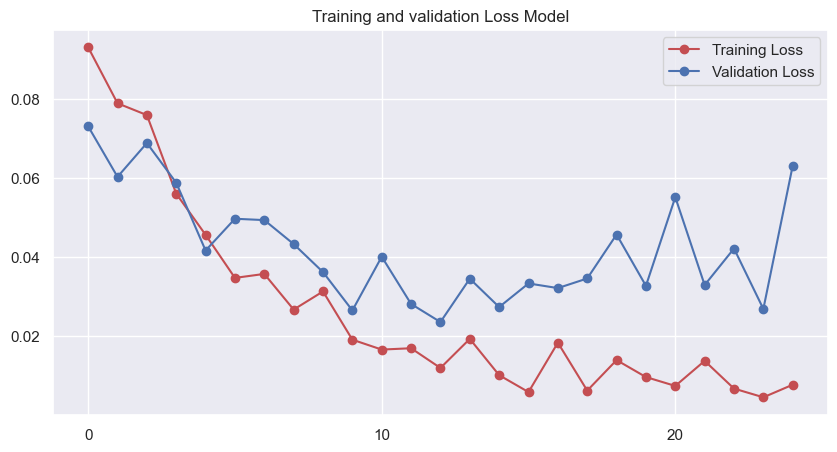

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['loss']
val_loss = history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Sparse categorical accuracy Model

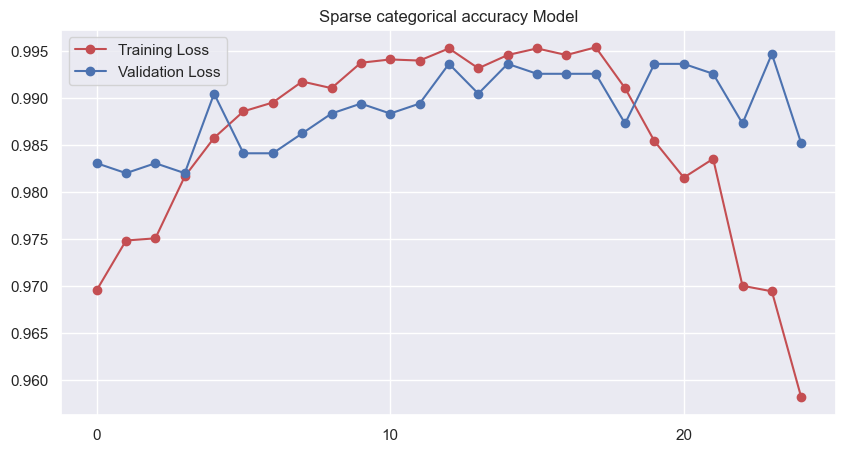

<Figure size 640x480 with 0 Axes>

In [24]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_sparse_categorical_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Sparse categorical accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared error in model

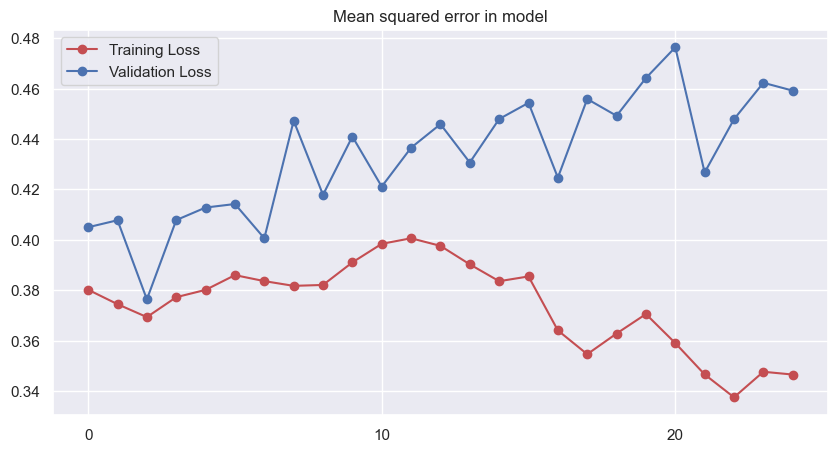

<Figure size 640x480 with 0 Axes>

In [25]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared absolute error in model

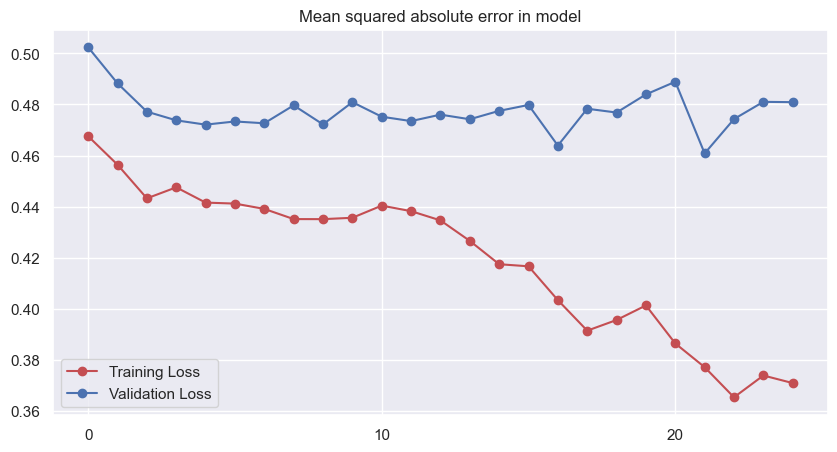

<Figure size 640x480 with 0 Axes>

In [26]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared absolute error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean absolute percentage error in model

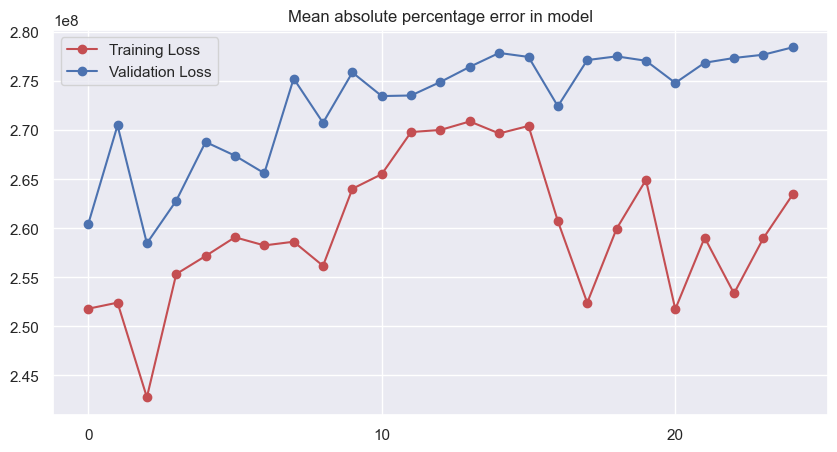

<Figure size 640x480 with 0 Axes>

In [27]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_percentage_error']
val_loss = history.history['val_mean_absolute_percentage_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean absolute percentage error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared logarithmic error in model

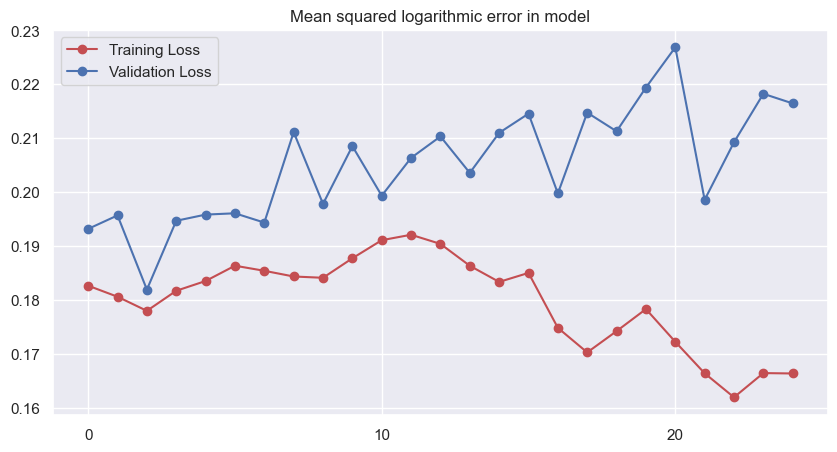

<Figure size 640x480 with 0 Axes>

In [28]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_logarithmic_error']
val_loss = history.history['val_mean_squared_logarithmic_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared logarithmic error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Cosine similarity in model

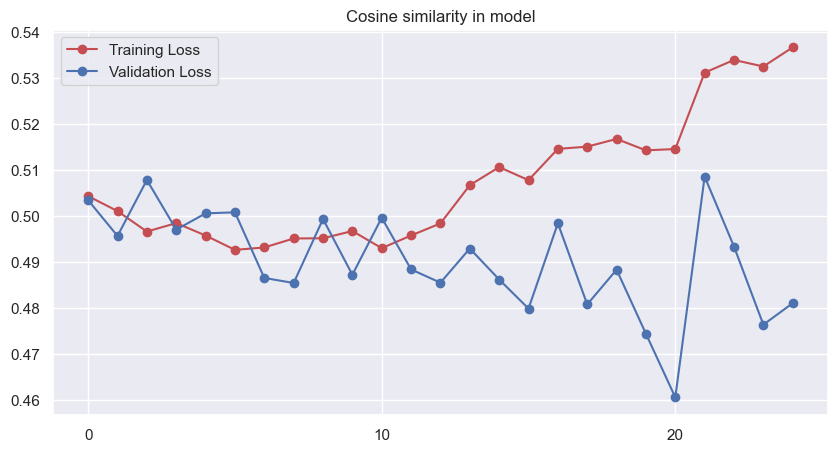

<Figure size 640x480 with 0 Axes>

In [29]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['cosine_similarity']
val_loss = history.history['val_cosine_similarity']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Cosine similarity in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Log-Cosh Loss

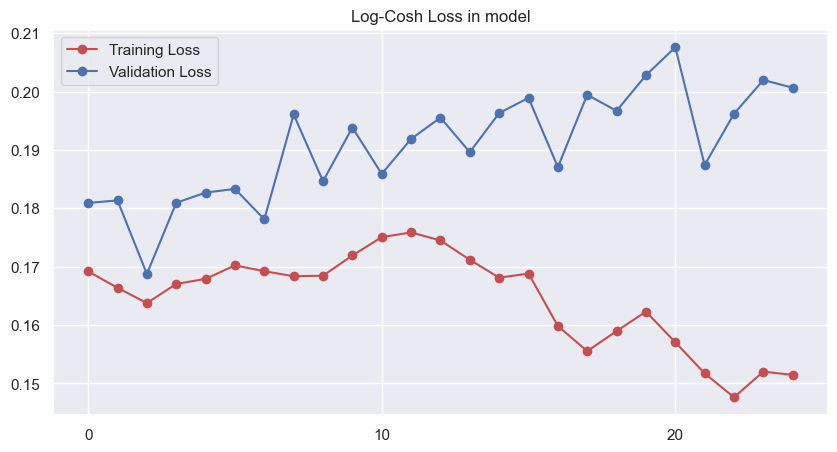

<Figure size 640x480 with 0 Axes>

In [30]:

sns.set()
epochs = range(0,len(acc))
loss = history.history['logcosh']
val_loss = history.history['val_logcosh']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Log-Cosh Loss in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

# Model Evaluation 

## Model Evaluation Results

In [31]:
score = model.evaluate(test_data,test_target)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 17s 538ms/step - loss: 0.0632 - accuracy: 0.9852 - sparse_categorical_accuracy: 0.9852 - mean_squared_error: 0.4592 - mean_absolute_error: 0.4809 - mean_absolute_percentage_error: 278477024.0000 - mean_squared_logarithmic_error: 0.2165 - cosine_similarity: 0.4811 - logcosh: 0.2007
Test loss: 0.06319959461688995
Test accuracy: 0.985200822353363


## Confution Matrix

 1/30 [>.............................] - ETA: 5s

2022-10-27 16:02:04.093020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 16s 544ms/step


<Figure size 1000x500 with 0 Axes>

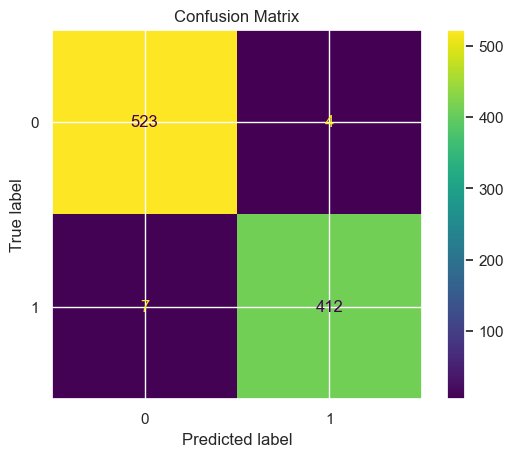

<Figure size 640x480 with 0 Axes>

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig = plt.gcf()
fig.set_size_inches(10, 5)

clf = model
pred = model.predict(x_test)[:, 1]
# print(pred)
predictions = (pred > 0.5).astype(int)
# print(predictions)
# print(y_test)
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.figure()
plt.show()

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)

523 4 7 412


## Sensitivity / True Positive Rate

In [34]:
# Sensitivity = True Positives/ (True Positives + True Negatives)
sensitivity = tp / (tp + tn)
print(f"Sensitivity : {sensitivity}")

Sensitivity : 0.4406417112299465


## Specificity / True Negative Rate:

In [35]:
# Specificity = True Negatives/ (False Positives + True Negatives)
specificity = tn / (fp+tn)
print(f"Specificity : {specificity}")

Specificity : 0.9924098671726755


## ROC AUC Score

In [36]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

# The area under the ROC curve (AUC) results were considered 
# excellent for AUC values between 0.9-1
# good for AUC values between 0.8-0.9 
# fair for AUC values between 0.7-0.8
# poor for AUC values between 0.6-0.7 
# failed for AUC values between 0.5-0.6


ROC AUC: 0.9879


## ROC Curve

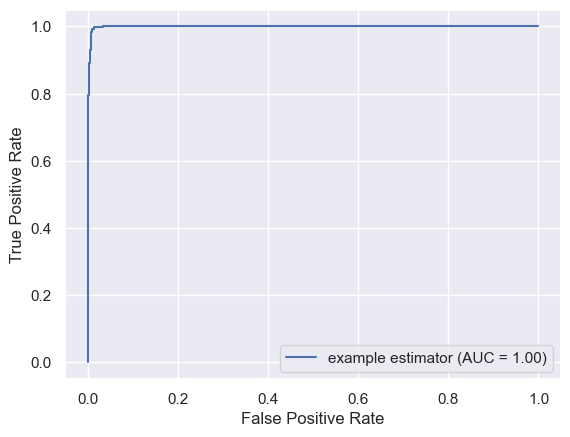

In [37]:
import matplotlib.pyplot as plt

from sklearn import metrics


fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
#plt.savefig('Multiclass Model .png')
plt.show()

##  Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       527
           1       0.99      0.98      0.99       419

    accuracy                           0.99       946
   macro avg       0.99      0.99      0.99       946
weighted avg       0.99      0.99      0.99       946



/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2148: UserWarning: labels size, 10, does not match size of target_names, 9
  warnings.warn(
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.p

<AxesSubplot: >

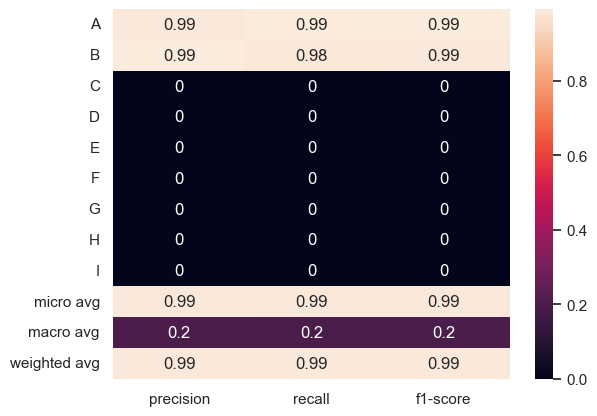

In [38]:
from sklearn.metrics import classification_report
import seaborn as sns
target_names = list("ABCDEFGHI")
labels = np.arange(10)

classification_report_1 = classification_report(y_test, predictions)
print(classification_report_1)
classification_report = classification_report(y_test, predictions,labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)


## Accuracy Score

In [39]:
from sklearn.metrics import accuracy_score
y_pred = predictions
y_true = y_test

ac_s_without_normalize = accuracy_score(y_true, y_pred)
print(f"Accuracy score without normalize : {ac_s_without_normalize}")

ac_s_with_normalize =accuracy_score(y_true, y_pred, normalize=False)
print(f"Accuracy score with normalize: {ac_s_with_normalize}")

Accuracy score without normalize : 0.9883720930232558
Accuracy score with normalize: 935


## Balance Accuracy Score

In [40]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy score : {balanced_accuracy_score}")

Balanced accuracy score : 0.9878517116292972


## Average precision score

In [41]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score(y_true, y_pred)
print(f"Average precision score : {average_precision_score}")

Average precision score : 0.9812383875213425


## Precision Score

Precision score macro : 0.9885885341074021
Precision score micro : 0.9883720930232558
Precision score weighted : 0.9883834846592636
Precision score : [0.98679245 0.99038462]


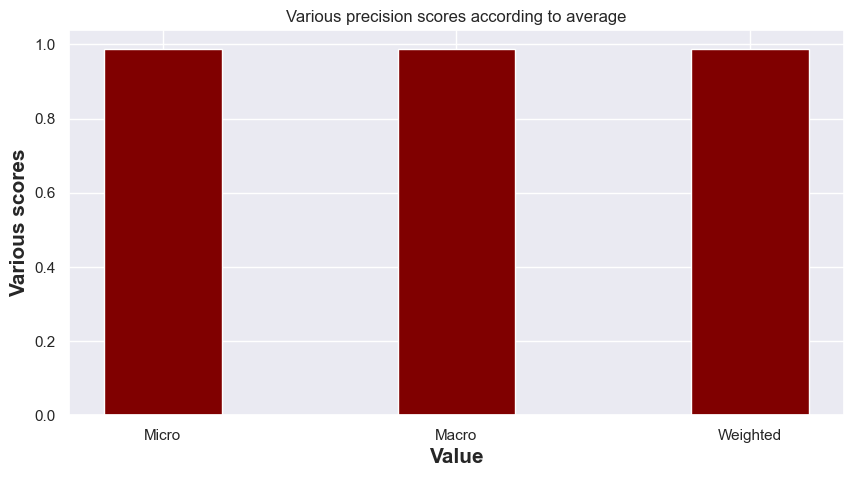

In [42]:
from sklearn.metrics import precision_score

precision_score_macro = precision_score(y_true, y_pred, average='macro')

precision_score_micro = precision_score(y_true, y_pred, average='micro')

precision_score_weighted = precision_score(y_true, y_pred, average='weighted')

precision_score = precision_score(y_true, y_pred, average=None)

print(f"Precision score macro : {precision_score_macro}")
print(f"Precision score micro : {precision_score_micro}")
print(f"Precision score weighted : {precision_score_weighted}")
print(f"Precision score : {precision_score}")


data = {'Micro':precision_score_macro, 'Macro':precision_score_micro, 'Weighted':precision_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various precision scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()


## Recall Score

Recall score macro : 0.9878517116292972
Recall score micro : 0.9883720930232558
Recall score weighted : 0.9883720930232558
Recall score : [0.99240987 0.98329356]


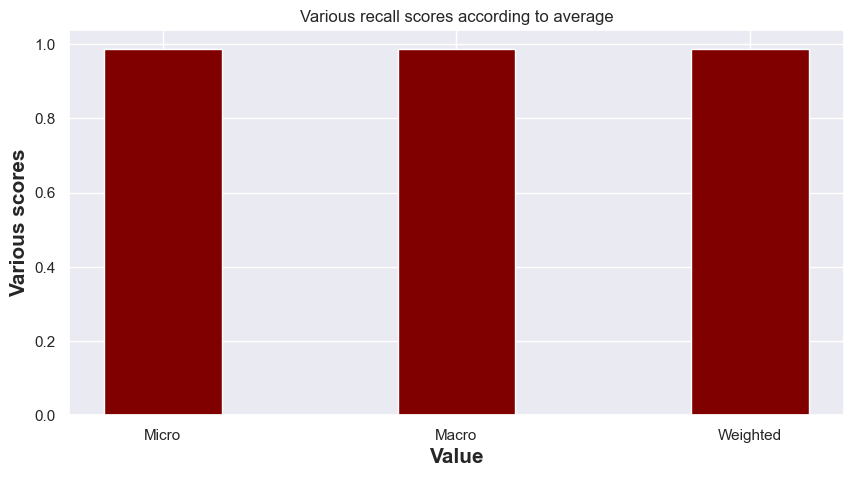

In [43]:
from sklearn.metrics import recall_score

recall_score_macro =recall_score(y_true, y_pred, average='macro')

recall_score_micro =recall_score(y_true, y_pred, average='micro')

recall_score_weighted =recall_score(y_true, y_pred, average='weighted')

recall_score =recall_score(y_true, y_pred, average=None)


print(f"Recall score macro : {recall_score_macro}")
print(f"Recall score micro : {recall_score_micro}")
print(f"Recall score weighted : {recall_score_weighted}")
print(f"Recall score : {recall_score}")

data = {'Micro':recall_score_macro, 'Macro':recall_score_micro, 'Weighted':recall_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various recall scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()

## F1 Score

Recall score macro : 0.9882097677870372
Recall score micro : 0.9883720930232558
Recall score weighted : 0.9883677058547093
Recall score : [0.98959319 0.98682635]


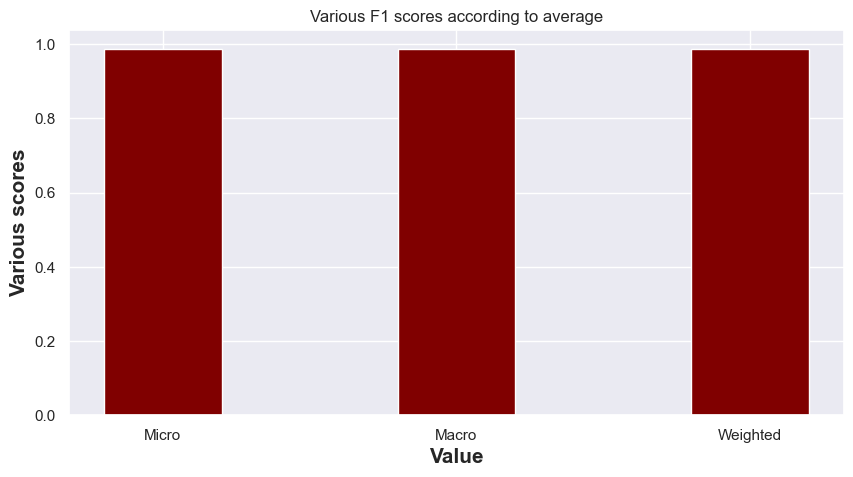

In [44]:
from sklearn.metrics import f1_score

f1_score_macro=f1_score(y_true, y_pred, average='macro')

f1_score_micro=f1_score(y_true, y_pred, average='micro')

f1_score_weighted=f1_score(y_true, y_pred, average='weighted')

f1_score=f1_score(y_true, y_pred, average=None)

print(f"Recall score macro : {f1_score_macro}")
print(f"Recall score micro : {f1_score_micro}")
print(f"Recall score weighted : {f1_score_weighted}")
print(f"Recall score : {f1_score}")

data = {'Micro':f1_score_macro, 'Macro':f1_score_micro, 'Weighted':f1_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various F1 scores according to average")
#plt.savefig('Multiclass Model .png')
plt.show()

## Binary accuracy

In [45]:
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)
print(f"Binary accuracy: {m}")


Binary accuracy: 0.9883720874786377


## Categorical accuracy

In [46]:
m = tf.keras.metrics.categorical_accuracy(y_true, y_pred)
print(f"Categorical accuracy: {m}")



Categorical accuracy: 1.0


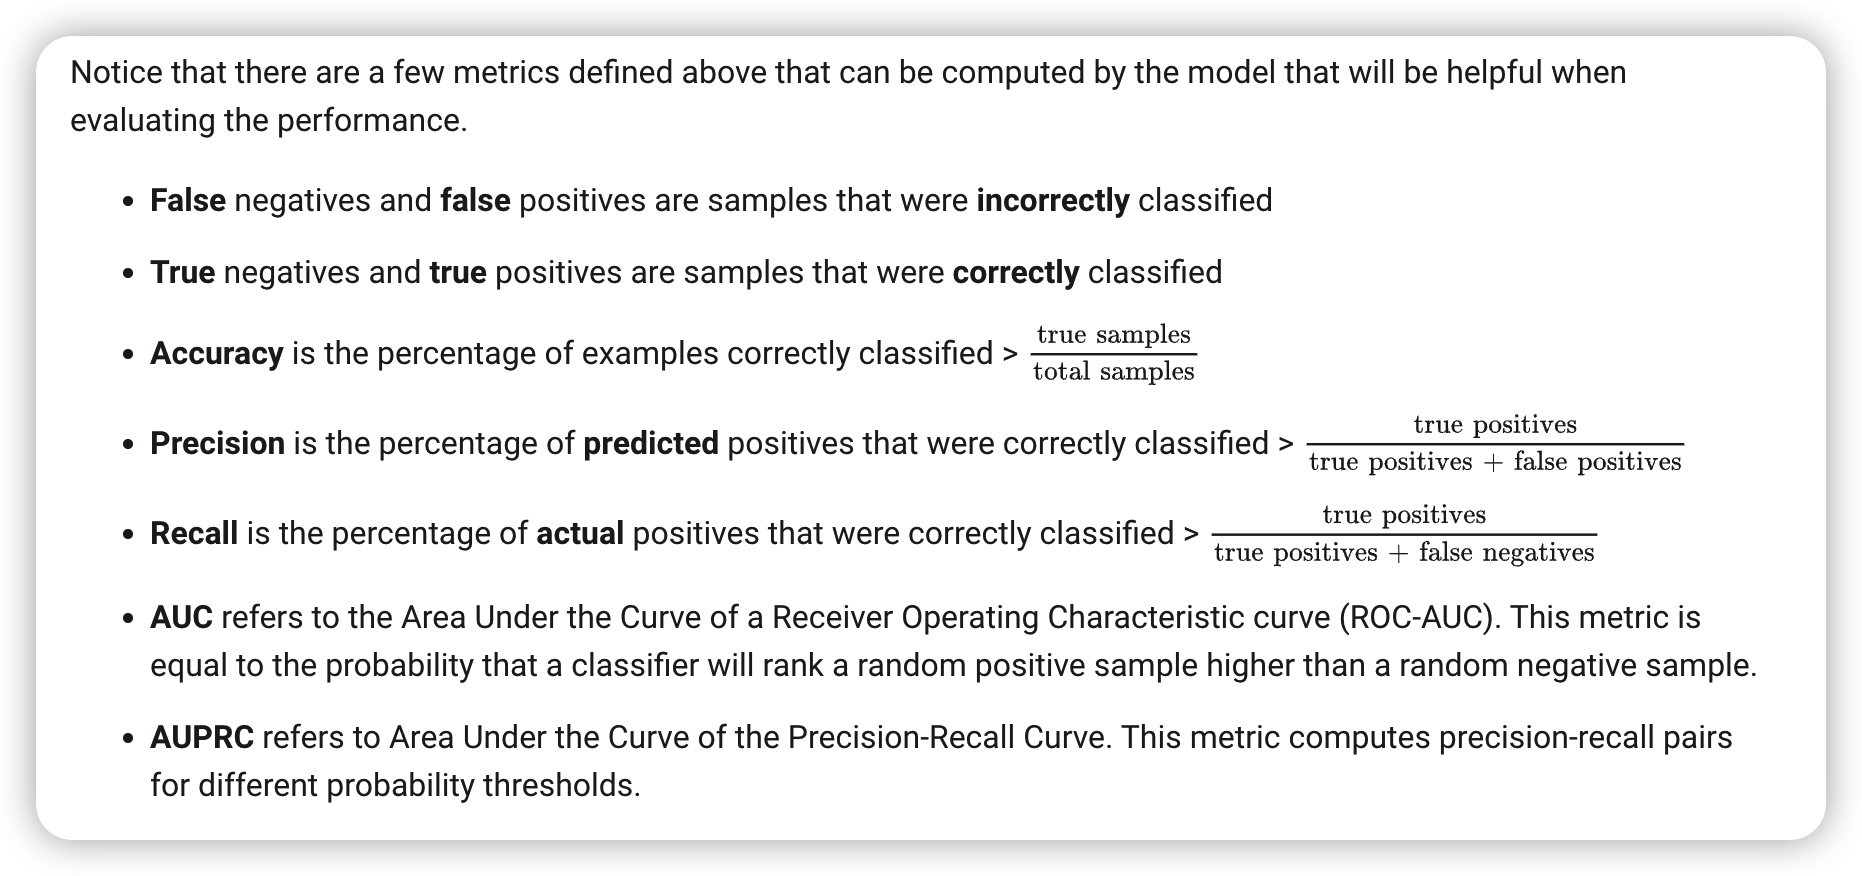

